In [3]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

import warnings
warnings.filterwarnings('ignore')

In [4]:
# data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
data_dir = "../input"
# train = pd.read_csv(data_dir + "/train_with_cluster.csv")
train = pd.read_csv(data_dir + "/training_set.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [5]:
nova = [15, 42, 52, 62, 67, 90]
novaes = meta.query("target == @nova")
train_novae = train.query("object_id in @novaes.object_id")

In [6]:
train_novae.head()

,object_id,mjd,passband,flux,flux_err,detected
702,730,59798.3205,2,1.177371,1.364300,0
703,730,59798.3281,1,2.320849,1.159247,0
704,730,59798.3357,3,2.939447,1.771328,0
705,730,59798.3466,4,2.128097,2.610659,0
706,730,59798.3576,5,-12.809639,5.380097,0


In [7]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'median', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    
    agg_df = pd.merge(agg_df, per_pass_agg_df, how="left", on="object_id")
    
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    agg_df.drop(["flux_min", "flux_max", "flux_diff"], axis=1, inplace=True)
    
    idxmax_df = df.reset_index().groupby("object_id").agg({"flux": "idxmax"})
    idxmax_df.rename(columns={"flux": "flux_idxmax"}, inplace=True)
    df3 = pd.merge(df, idxmax_df, how="left", on="object_id")
    # 片山変更
    # df3.drop(["cluster", "flux_err", "detected"], axis=1, inplace=True)
    df3.drop(["flux_err", "detected"], axis=1, inplace=True)
    df3["dummy_index"] = df3.index
    df3["index_diff"] = df3.dummy_index - df3.flux_idxmax
    df3 = df3.query("index_diff >= 0 & index_diff < 100")
    df3_mindf = df3.groupby("object_id").agg({
        "flux": "min"
    })
    df3_mindf.rename(columns={"flux": "flux_min"}, inplace=True)
    df3 = pd.merge(df3, df3_mindf, how="left", on="object_id")
    df3["flux"] = df3["flux"] - df3["flux_min"]
    df3["log_flux"] = np.log(df3["flux"] + 0.01)
    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        "cid_ce": [{"normalize": True}]
    }
    fcp2 = {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    }
    fcp3 = {
        "linear_trend": [{
            "attr": "pvalue"
        }, {
            "attr": "intercept"
        }, {
            "attr": "slope"
        }]
    }
    fcp_flux = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "mean_change": None,
        "mean_abs_change": None,
        "cid_ce": [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=6)
    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp2,
        n_jobs=4
    )
    agg_df_ts3 = extract_features(
        df3,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="log_flux",
        default_fc_parameters=fcp3,
        n_jobs=4
    )
    agg_df_flux = extract_features(
        df,
        column_id="object_id",
        column_value="flux",
        default_fc_parameters=fcp_flux,
        n_jobs=4
    )
    agg_df_ffrs = extract_features(
        df,
        column_id="object_id",
        column_value="flux_by_flux_ratio_sq",
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=4
    )
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=8)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts3, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on="id")
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def cluster_mean_diffcluster_mean_diff(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [8]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }


def process_meta(meta_df):
    meta_dict = dict()
    # distance
    meta_dict.update(haversine_plus(meta_df['ra'].values, meta_df['decl'].values, 
                   meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
            meta_df['hostgal_photoz'].values, 
             np.exp(meta_df['hostgal_photoz_err'].values))
    
    meta_df = pd.concat([meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df


def add_rank_bottom_and_top(df, feature_name):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    
    top_and_bottom = partial_values.groupby("object_id").agg({
        "variable": ["first", "last"]
    })
    top_and_bottom.columns = ["top"+feature_name, "bottom"+feature_name]
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        top_and_bottom = top_and_bottom.replace(n, i)
    top_and_bottom = top_and_bottom.astype(int)
    return top_and_bottom



def rank(df, feature_name, thres=20):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        partial_values.replace(n, i, inplace=True)
    partial_values["dummy"] = 1
    rank_feats = partial_values.groupby(["object_id", "dummy"]).agg({
        "variable": "sum"
    })
    d = dict()
    cnt = 0
    for i in rank_feats["variable"]:
        if i not in d.keys():
            d[i] = cnt
            cnt += 1
    rank_feats.reset_index(inplace=True)
    rank_feats.drop("dummy", axis=1, inplace=True)
    rank_feats.rename(columns={"variable": f"rank{feature_name}"}, inplace=True)
    rank_feats[f"rank{feature_name}"].replace(d, inplace=True)
    rank_dict = (rank_feats[f"rank{feature_name}"].value_counts() > thres).to_dict()
    rank_feats[f"rank{feature_name}"] = rank_feats[f"rank{feature_name}"].map(
        lambda x: x if rank_dict[x] else cnt+1
    )
    
    return rank_feats



def add_by_features(df, feature_name, new_feat_name):
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                df[f"{new_feat_name}{j}_by_{i}"] = df[f"{j}{feature_name}"] / df[f"{i}{feature_name}"]
    return df


In [9]:
def add_per_passband(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    return per_pass_agg_df

In [10]:
def get_full(df, meta):
    agg_basic = basic(df)
    # 片山変更
    # cl_mean_diff = cluster_mean_diff(df)
    # ps_std_diff = passband_std_difference(df)
    num_out = num_outliers(df)
    
    # 片山変更
    full = agg_basic
    # full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    # full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)
    full = pd.merge(full, meta, how="left", on="object_id")
    
    add_by_features(full, "__abs_energy_norm", "abs_energy")
    add_by_features(full, "__flux_diff", "flux_diff")
    add_by_features(full, "__flux_dif3", "flux_dif3")
    add_by_features(full, "__flux_by_flux_ratio_sq_sum", "flux_by_flux_ratio_sq_sum")
    add_by_features(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", "fft")
    add_by_features(full, "__linear_trend__attr_\"pvalue\"", "linear_p")
    add_by_features(full, "__linear_trend__attr_\"intercept\"", "linear_i")
    add_by_features(full, "__linear_trend__attr_\"slope\"", "linear_s")
    
    abs_energy = add_rank_bottom_and_top(full, "__abs_energy_norm")
    rank_abs_energy = rank(full, "__abs_energy_norm", 70)

    flux_diff = add_rank_bottom_and_top(full, "__flux_diff")
    rank_flux_diff = rank(full, "__flux_diff", 70)

    flux_dif3 = add_rank_bottom_and_top(full, "__flux_dif3")
    rank_flux_dif3 = rank(full, "__flux_dif3", 70)

    flux_by_flux_ratio_sq_sum = add_rank_bottom_and_top(full, "__flux_by_flux_ratio_sq_sum")
    rank_flux_by_flux_ratio_sq_sum = rank(full, "__flux_by_flux_ratio_sq_sum", 70)
    
    fc = add_rank_bottom_and_top(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm")
    rank_fc = rank(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", 70)
    
    linear_p = add_rank_bottom_and_top(full, "__linear_trend__attr_\"pvalue\"")
    rank_linear_p = rank(full, "__linear_trend__attr_\"pvalue\"", 70)
    
    linear_i = add_rank_bottom_and_top(full, "__linear_trend__attr_\"intercept\"")
    rank_linear_i = rank(full, "__linear_trend__attr_\"intercept\"", 70)
    
    linear_s = add_rank_bottom_and_top(full, "__linear_trend__attr_\"slope\"")
    rank_linear_s = rank(full, "__linear_trend__attr_\"slope\"", 70)
    full = pd.merge(full, rank_abs_energy, how="left", on="object_id")
    full = pd.merge(full, rank_flux_diff, how="left", on="object_id")
    full = pd.merge(full, rank_flux_dif3, how="left", on="object_id")
    full = pd.merge(full, abs_energy, how="left", on="object_id")
    full = pd.merge(full, flux_diff, how="left", on="object_id")
    full = pd.merge(full, flux_dif3, how="left", on="object_id")
    full = pd.merge(full, flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, rank_flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, fc, how="left", on="object_id")
    full = pd.merge(full, rank_fc, how="left", on="object_id")
    full = pd.merge(full, linear_p, how="left", on="object_id")
    full = pd.merge(full, rank_linear_p, how="left", on="object_id")
    full = pd.merge(full, linear_i, how="left", on="object_id")
    full = pd.merge(full, rank_linear_i, how="left", on="object_id")
    full = pd.merge(full, linear_s, how="left", on="object_id")
    full = pd.merge(full, rank_linear_s, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}

    for c in [15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [11]:
%%time
full, y, classes, class_weight, oof_df = train_data(train_novae, novaes)

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 85.60it/s] 


CPU times: user 40.1 s, sys: 1.96 s, total: 42.1 s
Wall time: 56.7 s


In [12]:
classes

[15, 42, 52, 62, 67, 90]

In [13]:
class_weight

{15: 2, 42: 1, 52: 1, 62: 1, 67: 1, 90: 1}

In [14]:
train_mean = full.mean(axis=0)
full.replace([np.inf, -np.inf], np.nan, inplace=True)
full.fillna(0, inplace=True)
full.head()

,flux_median,flux_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,0__flux_by_flux_ratio_sq_sum,1__flux_by_flux_ratio_sq_sum,2__flux_by_flux_ratio_sq_sum,...,"rank__fft_coefficient__coeff_0__attr_""abs""_norm","top__linear_trend__attr_""pvalue""","bottom__linear_trend__attr_""pvalue""","rank__linear_trend__attr_""pvalue""","top__linear_trend__attr_""intercept""","bottom__linear_trend__attr_""intercept""","rank__linear_trend__attr_""intercept""","top__linear_trend__attr_""slope""","bottom__linear_trend__attr_""slope""","rank__linear_trend__attr_""slope"""
0,0.409172,3.177854,0.069697,4124.451516,5.480405,1.046502e+05,5.989138,2.274455e+00,2.032471e+01,2.042918e+04,...,0,2,0,644,0,5,0,5,0,0
1,1.035895,4.979826,0.173789,94161.650792,9.611274,1.439125e+07,11.141069,4.016307e+03,3.510925e+06,5.506723e+06,...,1,3,0,644,0,3,1,4,0,634
2,1.141288,4.406298,0.173295,34324.179753,7.868462,3.015599e+06,7.908174,1.048432e+02,5.897740e+04,1.132796e+06,...,2,3,0,2,0,4,563,5,0,0
3,0.337299,6.278757,0.056818,285735.477529,6.381754,2.707323e+08,7.086625,4.949848e+06,7.693326e+07,8.285281e+07,...,510,0,5,3,0,5,0,0,5,2
4,0.623454,2.486305,0.008523,699.287831,4.861840,5.470282e+03,6.580398,5.630962e+01,3.162745e+01,2.829888e+01,...,0,4,0,4,0,5,0,3,0,634


In [15]:
def multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [16]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.savefig('importances_novae.png')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    class_names = ["class_15", "class_42", "class_52", "class_62", "class_67", "class_90"]
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix_novae.png")

In [17]:
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):     
    sm=SMOTE(random_state=2)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [59]:
def lgbm_modeling_cross_validation(params,
                                   full_train, 
                                   y, 
                                   classes, 
                                   class_weights, 
                                   nr_fold=12, 
                                   random_state=1, 
                                   save_plot=True, 
                                   show_log=True):

    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
   # print(weights)
   # weights=class_weights
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
                
        trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
        trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    
        val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
        
        categorical_feature = [
            "rank__abs_energy_norm", "rank__flux_diff", "rank__flux_dif3", "rank__flux_by_flux_ratio_sq_sum",
            "rank__fft_coefficient__coeff_0__attr_\"abs\"_norm", "rank__linear_trend__attr_\"pvalue\"", 
            "rank__linear_trend__attr_\"intercept\"", "rank__linear_trend__attr_\"slope\""
            ]
        categorical_feature = list(set(categorical_feature) & set(full_train.columns))
        
        clf = lgb.LGBMClassifier(**params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss_novae,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights),
            categorical_feature=categorical_feature
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        
        if show_log:
            print('no {}-fold loss: {}'.format(fold_ + 1, 
                  multi_weighted_logloss_novae(val_y, oof_preds[val_, :])))
    
        imp_df = pd.DataFrame({
                'feature': full_train.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_ + 1] * len(full_train.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = multi_weighted_logloss_novae(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    
    if save_plot:
        df_importances = save_importances(importances_=importances)
    
    return clfs, score, oof_preds

In [22]:
lgb_params = {
        'device': 'cpu', 
        'objective': 'binary',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'max_depth': 7, 
        'n_estimators': 500, 
        'subsample_freq': 2, 
        'subsample_for_bin': 5000, 
        'min_data_per_group': 100, 
        'max_cat_to_onehot': 4, 
        'cat_l2': 1.0, 
        'cat_smooth': 59.5, 
        'max_cat_threshold': 32, 
        'metric_freq': 10, 
        'verbosity': -1, 
        'metric': 'binary', 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'colsample_bytree': 0.5, 
        'drop_rate': 0.173, 
        'learning_rate': 0.0267, 
        'max_drop': 5, 
        'min_child_samples': 10, 
        'min_child_weight': 100.0, 
        'min_split_gain': 0.1, 
        'num_leaves': 7, 
        'reg_alpha': 0.1, 
        'reg_lambda': 0.00023, 
        'skip_drop': 0.44, 
        'subsample': 0.75
    }

novae_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 5, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 4,
    'n_estimators': 500,
    'num_leaves': 6,
    'learning_rate': 0.11,
    'drop_rate': 0.08,
    'subsample': 0.75,
    'subsample_freq': 2,
    'min_split_gain': 0.1,
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5
}

In [24]:
def plot_importances(clfs, features):
    importances = []
    for clf in clfs:
        importances.append(clf.feature_importances_)
    importances = pd.Series(np.array(importances).mean(axis=0), index=features)
    importances = importances.sort_values(ascending=False)

    fig, ax = plt.subplots(1,1,figsize=(14,14))
    importances.iloc[:40].plot(kind='barh', ax=ax)
    fig.tight_layout()

    return importances

### 元々のモデル

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.314414	training's wloss: 0.519784	valid_1's multi_logloss: 1.229	valid_1's wloss: 1.10176
Early stopping, best iteration is:
[112]	training's multi_logloss: 0.286239	training's wloss: 0.480135	valid_1's multi_logloss: 1.19313	valid_1's wloss: 1.09658
no 1-fold loss: 1.096581975439946
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.307279	training's wloss: 0.512993	valid_1's multi_logloss: 1.20064	valid_1's wloss: 1.11853
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.300209	training's wloss: 0.502752	valid_1's multi_logloss: 1.18993	valid_1's wloss: 1.11692
no 2-fold loss: 1.1169167299594966
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.315023	training's wloss: 0.520105	valid_1's multi_logloss: 1.23175	valid_1's wloss: 1.03677
Early stopping, best iteration is:
[115]	traini

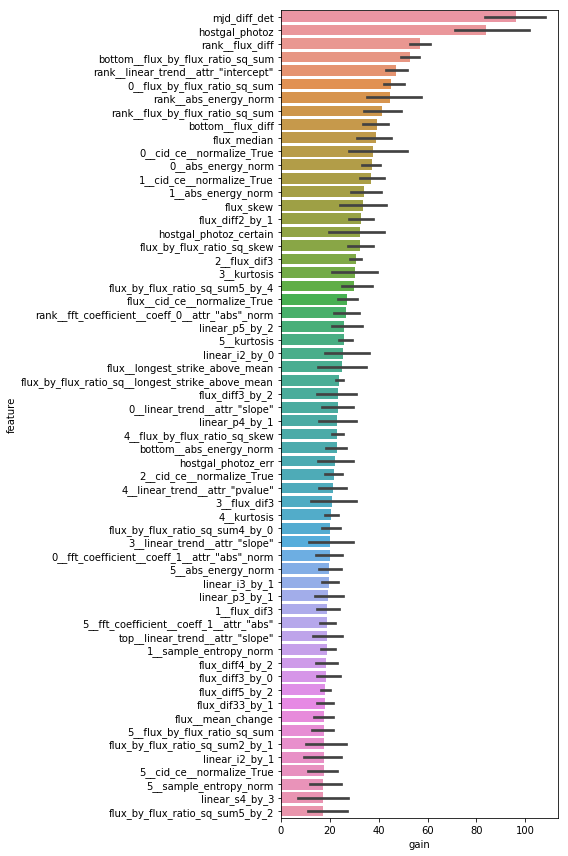

In [44]:
for cindex in full.columns:
    full.loc[:,cindex]=np.float64(full.loc[:,cindex])
clfs, score, oof_df = lgbm_modeling_cross_validation(
    novae_params, 
    full, 
    y, 
    classes,
    class_weight,
    5,
    7)

In [47]:
score

1.0874645169901165

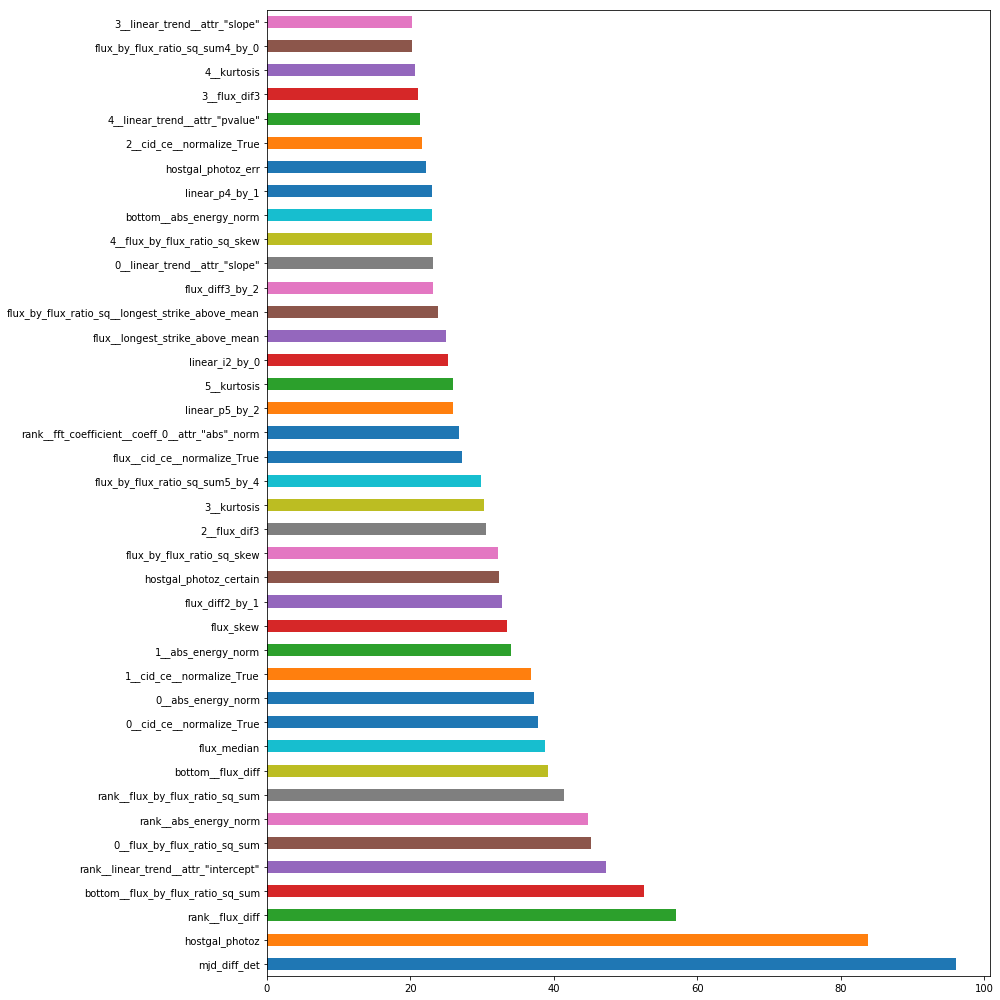

In [46]:
importances = plot_importances(clfs, full.columns)

Normalized confusion matrix


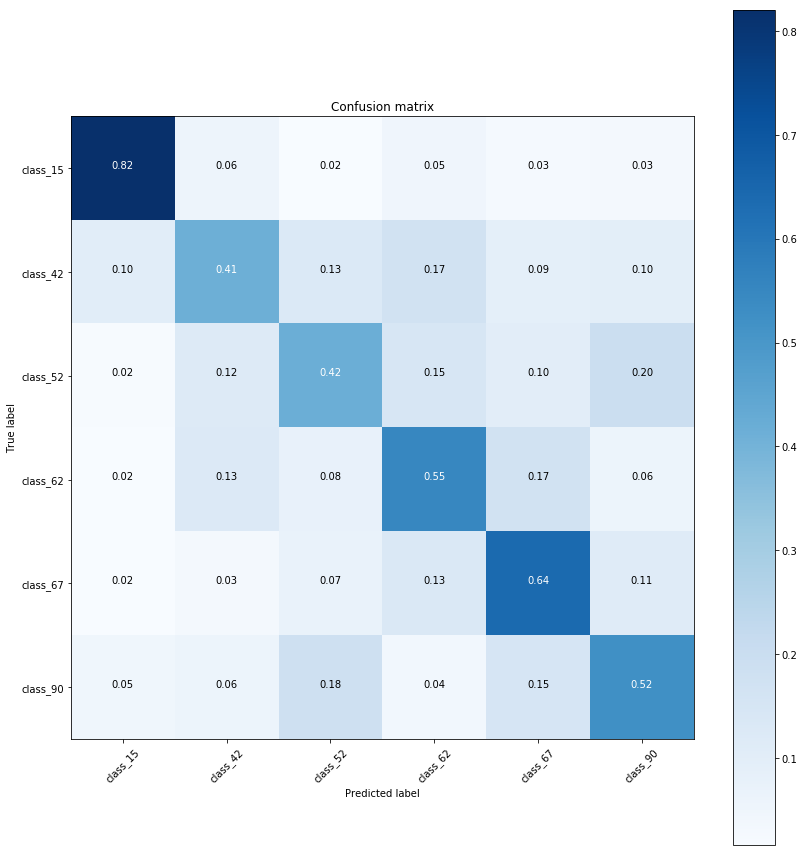

In [26]:
save_cm(y, oof_df)

### ハイパーパラメーターチューニング

In [38]:
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from functools import partial, wraps
import gc; gc.enable()

def tune_lgbm_paramters(X, y, classes, class_weights, n_calls):
    def objective(X, y, classes, class_weights, values):
        params = {
            'learning_rate': values[0],
            'min_child_weight': values[1], 
            'max_depth': values[2], 
            'colsample_bytree': values[3], 
            'subsample': values[4], 
            'reg_lambda': values[5], 
            'subsample_freq': values[6], 
            'subsample_for_bin': values[7], 
            'min_data_per_group': values[8], 
            'max_cat_to_onehot': values[9], 
            'cat_l2': values[10], 
            'cat_smooth': values[11], 
            'max_cat_threshold': values[12], 
            'metric_freq': values[13], 
            'drop_rate': values[14], 
            'max_drop': values[15], 
            'min_child_samples': values[16], 
            'min_split_gain': values[17], 
            'num_leaves': values[18], 
            'reg_alpha': values[19], 
            'skip_drop': values[20], 
            # 固定
            'device': 'cpu', 
            'objective': 'multiclass',  
            'boosting_type': 'gbdt', 
            'n_jobs': -1, 
            'xgboost_dart_mode': False, 
            'uniform_drop': False, 
            'verbosity': -1, 
            'metric': 'multi_logloss', 
            'n_estimators': 500,
        }

        _, score, _ = lgbm_modeling_cross_validation(params, 
                                                     X, 
                                                     y, 
                                                     classes, 
                                                     class_weights, 
                                                     nr_fold=3, 
                                                     random_state=7, 
                                                     save_plot=False, 
                                                     show_log=False)
        
        gc.collect()

        return score

    space  = [
        Real(0.01, 1.0, name='learning_rate'),
        Integer(10, 100, name='min_child_weight'),
        Integer(3, 50, name='max_depth'),
        Real(0.01, 1.0, name='colsample_bytree'),
        Real(0.01, 1.0, name='subsample'),
        Real(1e-9, 1000, name='reg_lambda'),
        Integer(0, 5, name='subsample_freq'),
        Integer(100, 6000, name='subsample_for_bin'),
        Integer(10, 2000, name='min_data_per_group'),
        Integer(1, 10, name='max_cat_to_onehot'),
        Real(1e-9, 2.0, name='cat_l2'),
        Real(10, 100, name='cat_smooth'),
        Integer(4, 64, name='max_cat_threshold'),
        Integer(1, 10, name='metric_freq'),
        Real(1e-9, 1.0, name='drop_rate'),
        Integer(0, 10, name='max_drop'),
        Integer(3, 30, name='min_child_samples'),
        Real(1e-9, 1.0, name='min_split_gain'),
        Integer(3, 15, name='num_leaves'),
        Real(1e-9, 1.0, name='reg_alpha'),
        Real(1e-9, 1.0, name='skip_drop'),
    ]

    objective = partial(objective, X, y, classes, class_weights)
    res_gp = gp_minimize(objective, space, n_calls=n_calls, random_state=0, n_random_starts=10)

    
    best_params = {
        'learning_rate': res_gp.x[0],
        'min_child_weight': res_gp.x[1], 
        'max_depth': res_gp.x[2], 
        'colsample_bytree': res_gp.x[3], 
        'subsample': res_gp.x[4], 
        'reg_lambda': res_gp.x[5], 
        'subsample_freq': res_gp.x[6], 
        'subsample_for_bin': res_gp.x[7], 
        'min_data_per_group': res_gp.x[8], 
        'max_cat_to_onehot': res_gp.x[9], 
        'cat_l2': res_gp.x[10], 
        'cat_smooth': res_gp.x[11], 
        'max_cat_threshold': res_gp.x[12], 
        'metric_freq': res_gp.x[13], 
        'drop_rate': res_gp.x[14], 
        'max_drop': res_gp.x[15], 
        'min_child_samples': res_gp.x[16], 
        'min_split_gain': res_gp.x[17], 
        'num_leaves': res_gp.x[18], 
        'reg_alpha': res_gp.x[19], 
        'skip_drop': res_gp.x[20], 
        # 固定
        'device': 'cpu', 
        'objective': 'multiclass',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'metric': 'multi_logloss', 
        'n_estimators': 500,
    }

    return best_params


In [39]:
%%time
best_params = tune_lgbm_paramters(full, y, classes, class_weight, 40)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[25]	training's multi_logloss: 0.330944	training's wloss: 0.607065	valid_1's multi_logloss: 1.36753	valid_1's wloss: 1.1699
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.269288	training's wloss: 0.497888	valid_1's multi_logloss: 1.26611	valid_1's wloss: 1.12527
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.262478	training's wloss: 0.494502	valid_1's multi_logloss: 1.2831	valid_1's wloss: 1.1713
MULTI WEIGHTED LOG LOSS: 1.15547
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	training's multi_logloss: 0.267309	training's wloss: 0.514835	valid_1's multi_logloss: 1.36008	valid_1's wloss: 1.24394
Training until validation scores don't improve for 50 rounds.
Early stopping, best

Early stopping, best iteration is:
[19]	training's multi_logloss: 0.272575	training's wloss: 0.541308	valid_1's multi_logloss: 1.44205	valid_1's wloss: 1.26071
MULTI WEIGHTED LOG LOSS: 1.24613
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[23]	training's multi_logloss: 0.258729	training's wloss: 0.513919	valid_1's multi_logloss: 1.35269	valid_1's wloss: 1.18159
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[23]	training's multi_logloss: 0.277364	training's wloss: 0.529945	valid_1's multi_logloss: 1.33903	valid_1's wloss: 1.08602
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	training's multi_logloss: 0.25856	training's wloss: 0.504293	valid_1's multi_logloss: 1.30384	valid_1's wloss: 1.12997
MULTI WEIGHTED LOG LOSS: 1.13264
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 1.1665	training

[400]	training's multi_logloss: 0.634479	training's wloss: 1.05514	valid_1's multi_logloss: 2.02802	valid_1's wloss: 1.3489
[500]	training's multi_logloss: 0.567241	training's wloss: 0.962501	valid_1's multi_logloss: 1.90452	valid_1's wloss: 1.29119
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.567241	training's wloss: 0.962501	valid_1's multi_logloss: 1.90452	valid_1's wloss: 1.29119
MULTI WEIGHTED LOG LOSS: 1.26115
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 1.09007	training's wloss: 1.60223	valid_1's multi_logloss: 2.55576	valid_1's wloss: 1.70244
[200]	training's multi_logloss: 0.874453	training's wloss: 1.34393	valid_1's multi_logloss: 2.31507	valid_1's wloss: 1.5108
[300]	training's multi_logloss: 0.742638	training's wloss: 1.17665	valid_1's multi_logloss: 2.11848	valid_1's wloss: 1.39567
[400]	training's multi_logloss: 0.650541	training's wloss: 1.05415	valid_1's multi_logloss: 1.95893	valid_1'

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.787415	training's wloss: 1.24195	valid_1's multi_logloss: 2.28071	valid_1's wloss: 1.44724
[200]	training's multi_logloss: 0.588003	training's wloss: 0.986688	valid_1's multi_logloss: 1.93848	valid_1's wloss: 1.3044
[300]	training's multi_logloss: 0.471052	training's wloss: 0.821643	valid_1's multi_logloss: 1.69382	valid_1's wloss: 1.22354
[400]	training's multi_logloss: 0.3955	training's wloss: 0.714077	valid_1's multi_logloss: 1.55007	valid_1's wloss: 1.17953
[500]	training's multi_logloss: 0.340727	training's wloss: 0.634321	valid_1's multi_logloss: 1.44794	valid_1's wloss: 1.16155
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.340727	training's wloss: 0.634321	valid_1's multi_logloss: 1.44794	valid_1's wloss: 1.16155
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.828236	training's wloss: 1.28488	valid_1's

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.429218	training's wloss: 0.786611	valid_1's multi_logloss: 1.67427	valid_1's wloss: 1.14363
[200]	training's multi_logloss: 0.267138	training's wloss: 0.528783	valid_1's multi_logloss: 1.32741	valid_1's wloss: 1.06372
[300]	training's multi_logloss: 0.195455	training's wloss: 0.406446	valid_1's multi_logloss: 1.17074	valid_1's wloss: 1.04846
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.225193	training's wloss: 0.457301	valid_1's multi_logloss: 1.2332	valid_1's wloss: 1.04642
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.420956	training's wloss: 0.78173	valid_1's multi_logloss: 1.70881	valid_1's wloss: 1.18836
[200]	training's multi_logloss: 0.264021	training's wloss: 0.528106	valid_1's multi_logloss: 1.33839	valid_1's wloss: 1.10025
[300]	training's multi_logloss: 0.195017	training's wloss: 0.410193	valid_1's multi_log

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.43278	training's wloss: 0.803048	valid_1's multi_logloss: 1.70979	valid_1's wloss: 1.14579
[200]	training's multi_logloss: 0.269725	training's wloss: 0.538898	valid_1's multi_logloss: 1.33776	valid_1's wloss: 1.05661
[300]	training's multi_logloss: 0.195369	training's wloss: 0.408888	valid_1's multi_logloss: 1.17662	valid_1's wloss: 1.04482
Early stopping, best iteration is:
[280]	training's multi_logloss: 0.20667	training's wloss: 0.428095	valid_1's multi_logloss: 1.19425	valid_1's wloss: 1.04138
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.420395	training's wloss: 0.793069	valid_1's multi_logloss: 1.75596	valid_1's wloss: 1.20332
[200]	training's multi_logloss: 0.26372	training's wloss: 0.534103	valid_1's multi_logloss: 1.3715	valid_1's wloss: 1.10266
[300]	training's multi_logloss: 0.193167	training's wloss: 0.407425	valid_1's multi_loglo

Early stopping, best iteration is:
[107]	training's multi_logloss: 0.225116	training's wloss: 0.438845	valid_1's multi_logloss: 1.20146	valid_1's wloss: 1.04797
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.237831	training's wloss: 0.464796	valid_1's multi_logloss: 1.26578	valid_1's wloss: 1.08504
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.173861	training's wloss: 0.357851	valid_1's multi_logloss: 1.14237	valid_1's wloss: 1.07717
MULTI WEIGHTED LOG LOSS: 1.08030
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.558366	training's wloss: 0.922566	valid_1's multi_logloss: 1.843	valid_1's wloss: 1.29489
[200]	training's multi_logloss: 0.335378	training's wloss: 0.609169	valid_1's multi_logloss: 1.45263	valid_1's wloss: 1.18935
[300]	training's multi_logloss: 0.2256	training's wloss: 0.435782	valid_1's multi_logloss: 1.23602	valid_1's wloss: 1.15749
Early stopping, best 

In [40]:
import pickle
with open('./novae_bestmodel.pickle', mode='wb') as f:
    pickle.dump(best_params, f)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.421479	training's wloss: 0.776093	valid_1's multi_logloss: 1.67939	valid_1's wloss: 1.19369
[200]	training's multi_logloss: 0.265911	training's wloss: 0.528034	valid_1's multi_logloss: 1.33192	valid_1's wloss: 1.12839
[300]	training's multi_logloss: 0.194023	training's wloss: 0.403484	valid_1's multi_logloss: 1.1676	valid_1's wloss: 1.11445
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.198177	training's wloss: 0.41145	valid_1's multi_logloss: 1.17672	valid_1's wloss: 1.11236
no 1-fold loss: 1.1123550750039133
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.418001	training's wloss: 0.775187	valid_1's multi_logloss: 1.65452	valid_1's wloss: 1.1792
[200]	training's multi_logloss: 0.266074	training's wloss: 0.523079	valid_1's multi_logloss: 1.27096	valid_1's wloss: 1.08679
[300]	training's multi_logloss: 0.195669	training's w

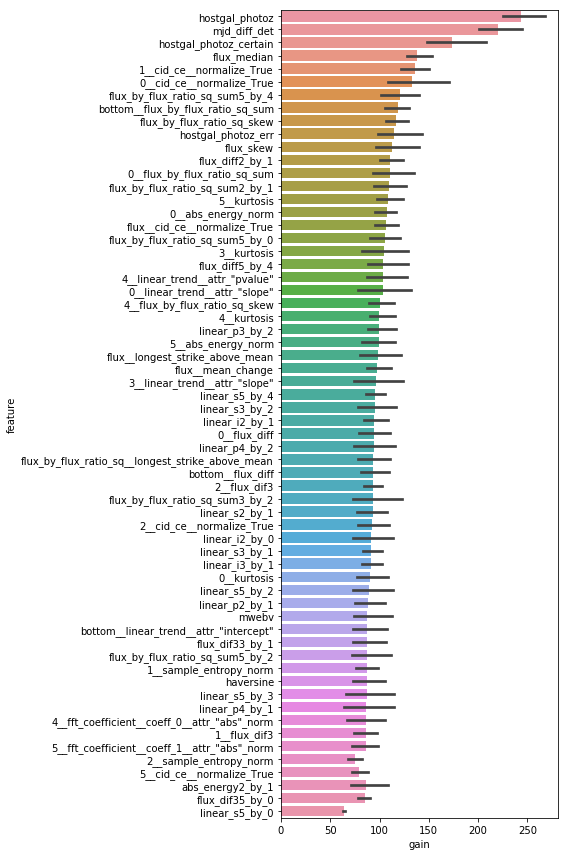

In [48]:
clfs, score, oof_df = lgbm_modeling_cross_validation(
    best_params, 
    full, 
    y, 
    classes,
    class_weight,
    5,
    7)

In [49]:
score

1.0606554706523288

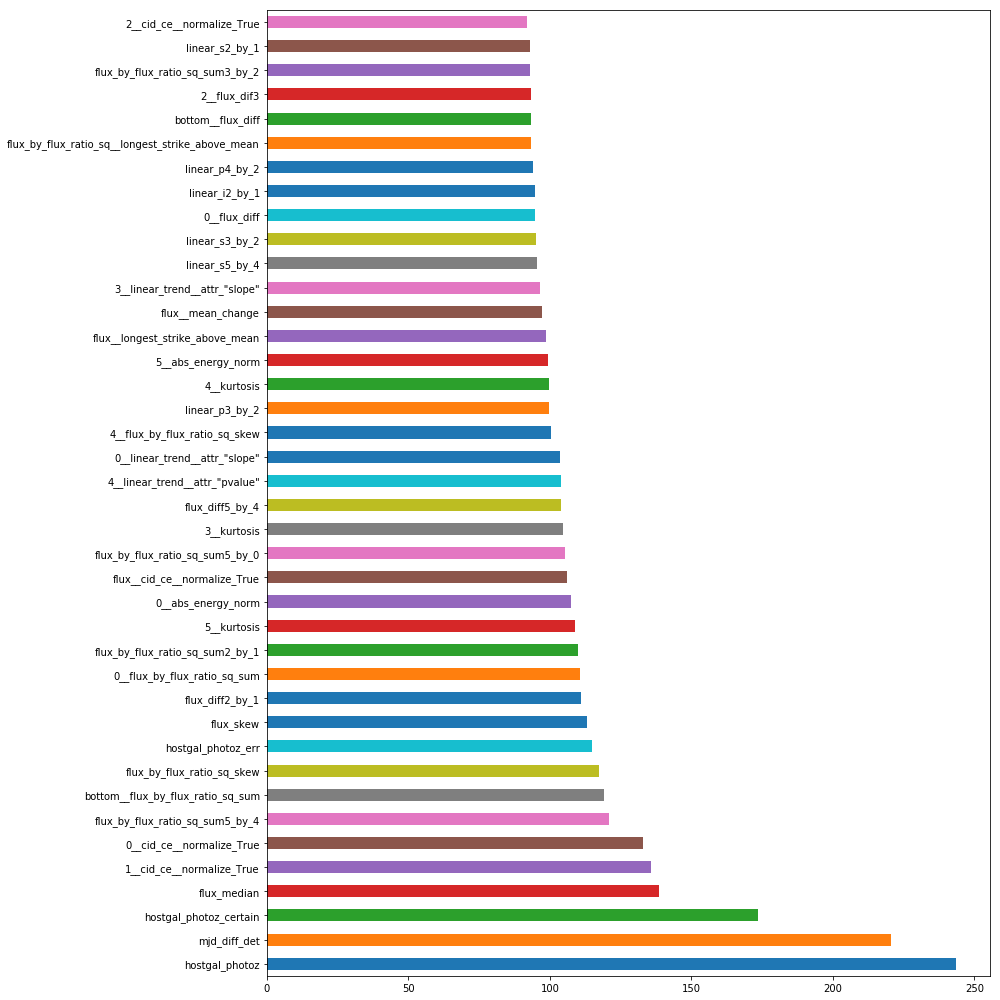

In [50]:
importances = plot_importances(clfs, full.columns)

Normalized confusion matrix


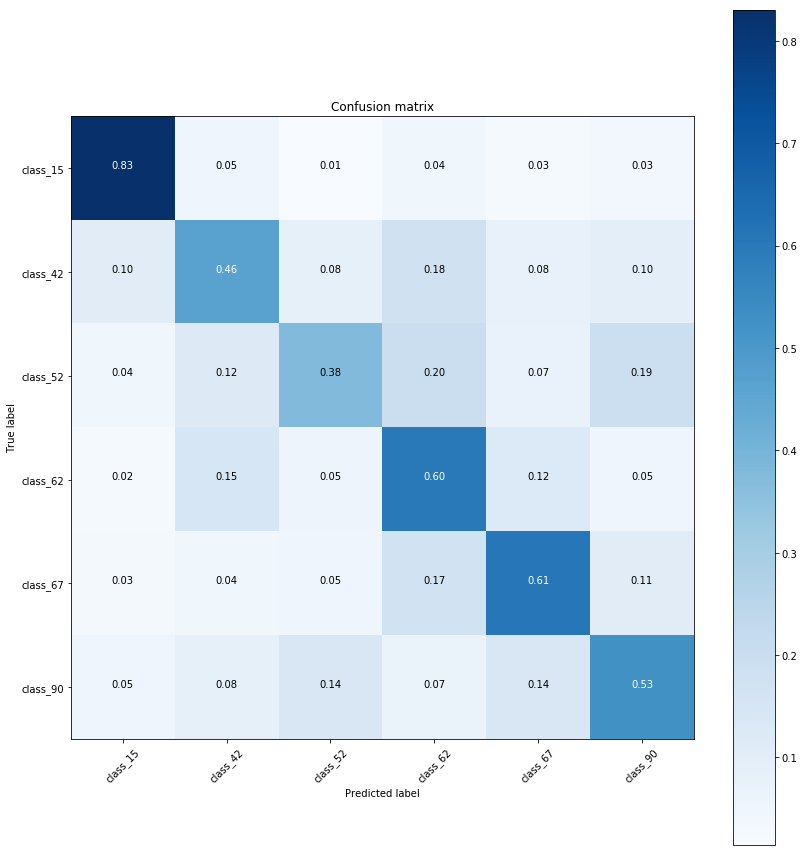

In [51]:
print(score)
save_cm(y, oof_df)

### 特徴量選択

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.466099	training's wloss: 0.843069	valid_1's multi_logloss: 1.76773	valid_1's wloss: 1.20306
[200]	training's multi_logloss: 0.30031	training's wloss: 0.59096	valid_1's multi_logloss: 1.42531	valid_1's wloss: 1.10659
[300]	training's multi_logloss: 0.223109	training's wloss: 0.461792	valid_1's multi_logloss: 1.25926	valid_1's wloss: 1.07737
Early stopping, best iteration is:
[331]	training's multi_logloss: 0.20686	training's wloss: 0.433008	valid_1's multi_logloss: 1.22085	valid_1's wloss: 1.07152
no 1-fold loss: 1.0715224588477146
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.456456	training's wloss: 0.833028	valid_1's multi_logloss: 1.72107	valid_1's wloss: 1.18937
[200]	training's multi_logloss: 0.29568	training's wloss: 0.576683	valid_1's multi_logloss: 1.34656	valid_1's wloss: 1.09067
[300]	training's multi_logloss: 0.220664	training's wl

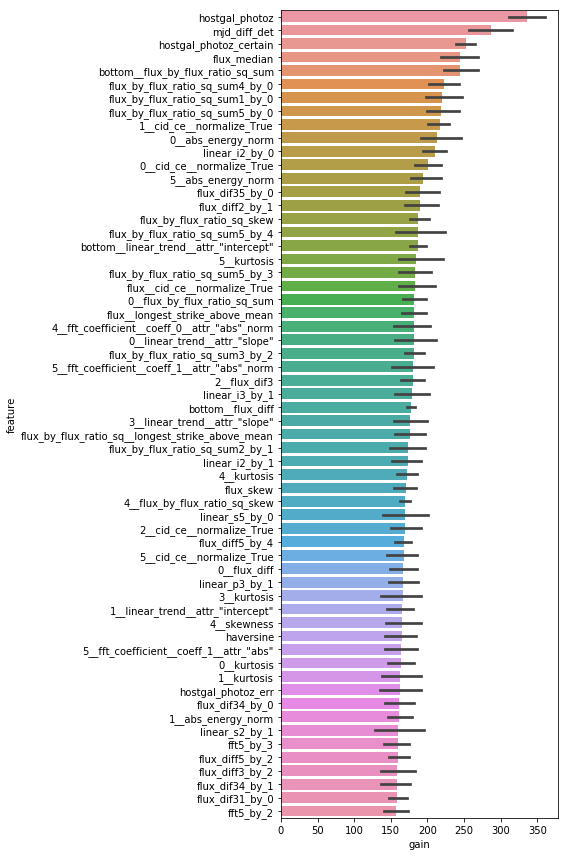

In [71]:
features = importances.iloc[:-130].index.tolist()
clfs, score, oof_df = lgbm_modeling_cross_validation(
    best_params, 
    full[features], 
    y, 
    classes,
    class_weight,
    5,
    7)

1.0355152521764337
Normalized confusion matrix


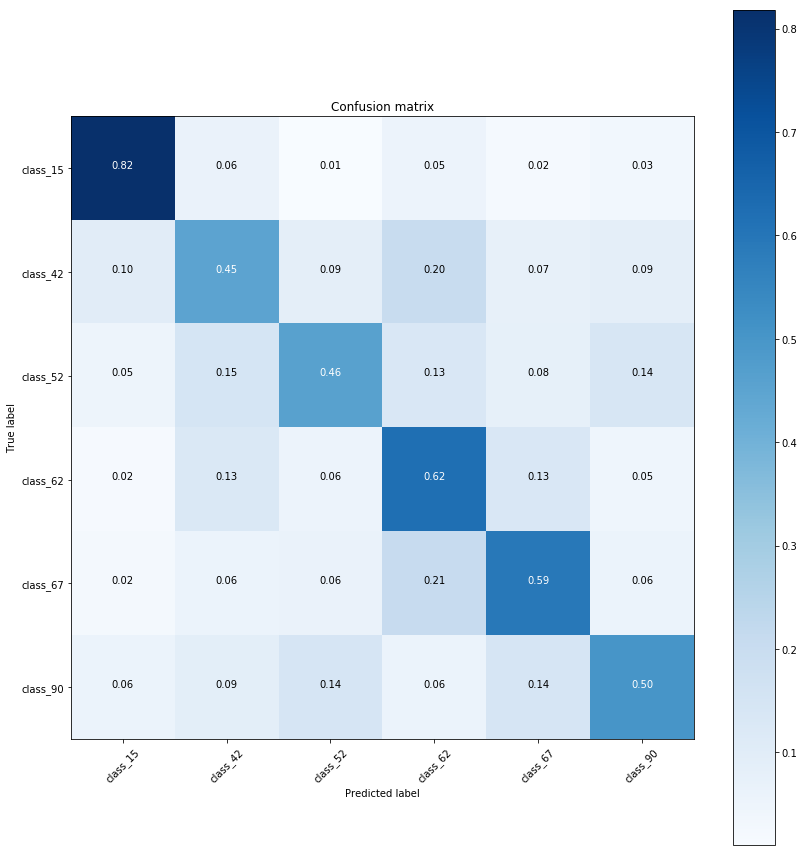

In [72]:
# 100 1.0546022922390468
# 120 1.0380779710934063
# 130 1.0355152521764337
# 140 1.0373412973185983
# 150 1.0393855102799034

print(score)
save_cm(y, oof_df)

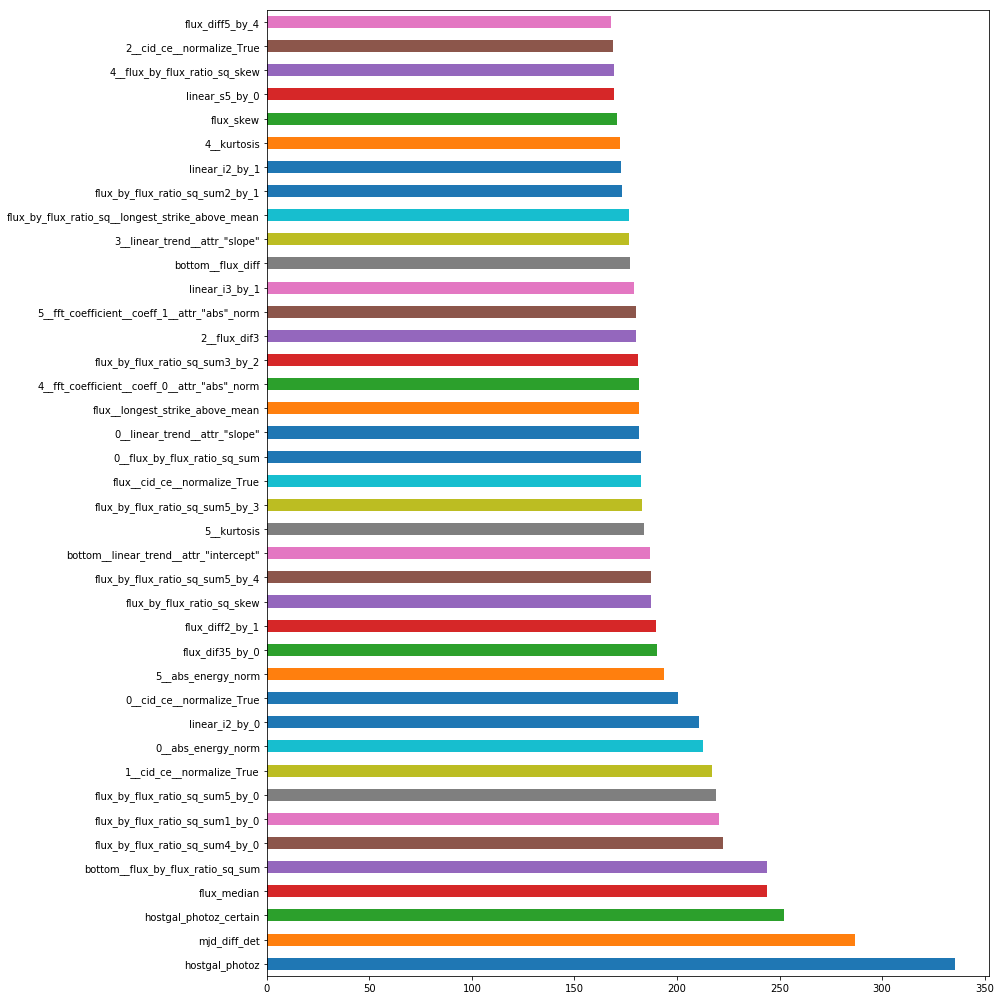

In [74]:
best_importances = plot_importances(clfs, full[features].columns)